In [2013]:
import pandas as pd
import numpy as np
import seaborn as sbrn
import missingno as msno
import pylab
import math
import pickle
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (InputLayer, Dense, Flatten, Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.manifold import Isomap
from scipy import stats

# CSCM35 - Coursework 2 - 2023638

<p>Futher we present a solution for our coursework which is centered around predicting selling real estate prices.</p>

<h2>Data preparation</h2>

<p>Reading the data</p>

In [2014]:
data = pd.read_csv('./Dataset/House_Price_Dataset.csv')

In [2015]:
data.head()

,Suburb,Address,Rooms,Type,Price,Method,Seller,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Latitude,Longitude,RegionName,PropertyCount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,03/09/2016,2.50,3067.00,...,1.00,1.00,126.00,NaN,NaN,Yarra City Council,-37.80,145.00,Northern Metropolitan,4019.00
1,Abbotsford,85 Turner St,2,h,1480000.00,S,Biggin,03/12/2016,2.50,3067.00,...,1.00,1.00,202.00,NaN,NaN,Yarra City Council,-37.80,145.00,Northern Metropolitan,4019.00
2,Abbotsford,25 Bloomburg St,2,h,1035000.00,S,Biggin,04/02/2016,2.50,3067.00,...,1.00,0.00,156.00,79.00,1900.00,Yarra City Council,-37.81,144.99,Northern Metropolitan,4019.00
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,04/02/2016,2.50,3067.00,...,2.00,1.00,0.00,NaN,NaN,Yarra City Council,-37.81,145.01,Northern Metropolitan,4019.00
4,Abbotsford,5 Charles St,3,h,1465000.00,SP,Biggin,04/03/2017,2.50,3067.00,...,2.00,0.00,134.00,150.00,1900.00,Yarra City Council,-37.81,144.99,Northern Metropolitan,4019.00


In [2016]:
## Statistical information about the data, which we will often call again further
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         34857 non-null  object 
 1   Address        34857 non-null  object 
 2   Rooms          34857 non-null  int64  
 3   Type           34857 non-null  object 
 4   Price          27247 non-null  float64
 5   Method         34857 non-null  object 
 6   Seller         34857 non-null  object 
 7   Date           34857 non-null  object 
 8   Distance       34856 non-null  float64
 9   Postcode       34856 non-null  float64
 10  Rooms2         26640 non-null  float64
 11  Bathroom       26631 non-null  float64
 12  Car            26129 non-null  float64
 13  Landsize       23047 non-null  float64
 14  BuildingArea   13742 non-null  float64
 15  YearBuilt      15551 non-null  float64
 16  CouncilArea    34854 non-null  object 
 17  Latitude       26881 non-null  float64
 18  Longit

In [1989]:
data = data[~data['Price'].isnull()]

In [1990]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27247 entries, 1 to 34856
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         27247 non-null  object 
 1   Address        27247 non-null  object 
 2   Rooms          27247 non-null  int64  
 3   Type           27247 non-null  object 
 4   Price          27247 non-null  float64
 5   Method         27247 non-null  object 
 6   Seller         27247 non-null  object 
 7   Date           27247 non-null  object 
 8   Distance       27246 non-null  float64
 9   Postcode       27246 non-null  float64
 10  Rooms2         20806 non-null  float64
 11  Bathroom       20800 non-null  float64
 12  Car            20423 non-null  float64
 13  Landsize       17982 non-null  float64
 14  BuildingArea   10656 non-null  float64
 15  YearBuilt      12084 non-null  float64
 16  CouncilArea    27244 non-null  object 
 17  Latitude       20993 non-null  float64
 18  Longit

<AxesSubplot:>

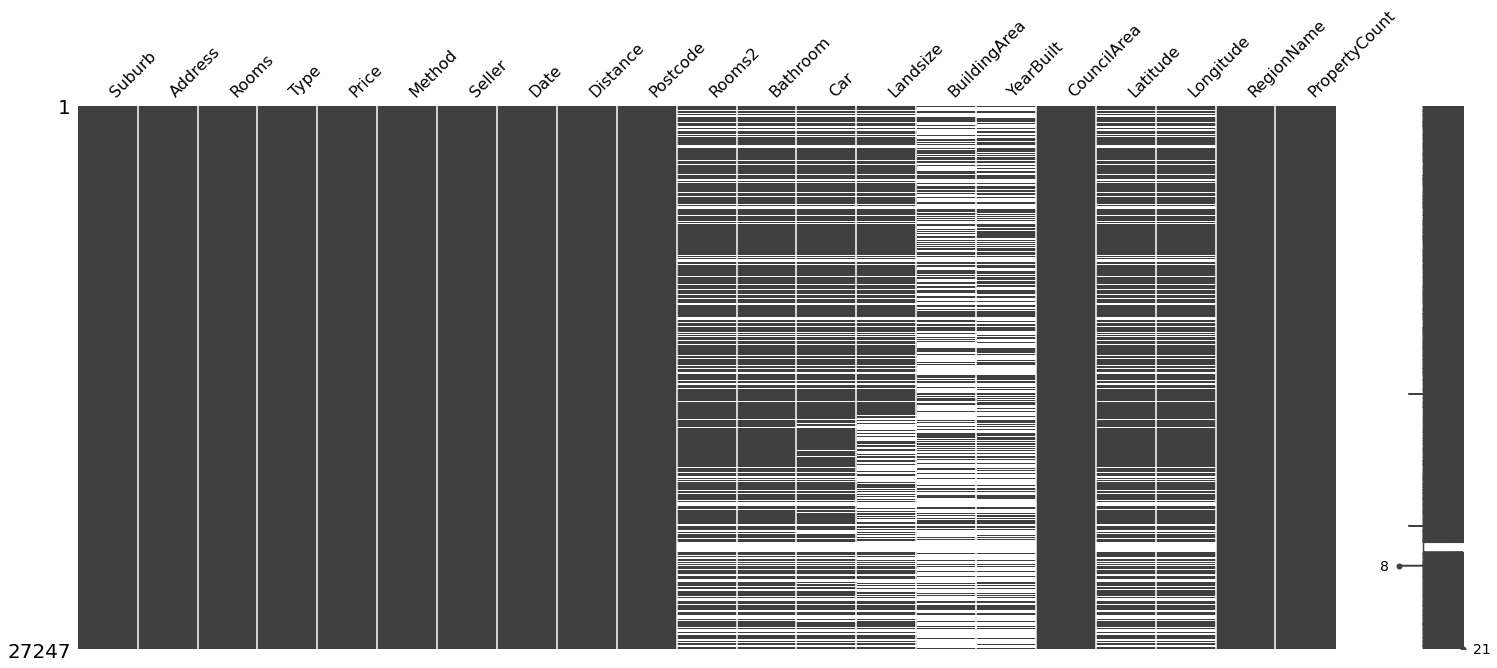

In [1991]:
## missing values
msno.matrix(data)

<AxesSubplot:>

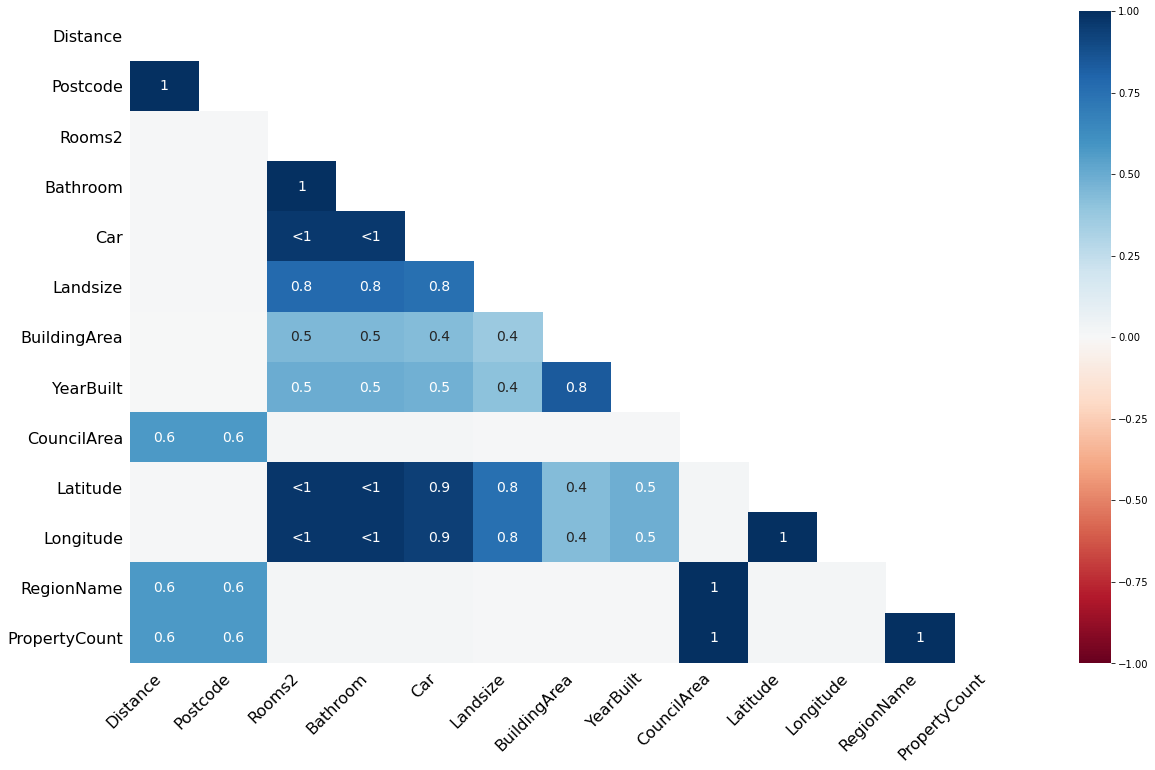

In [1992]:
## missing values correlation
msno.heatmap(data)

In [1993]:
## merge the given information about rooms
data['Rooms'] = (data.apply(lambda row: (row.Rooms + row.Rooms2) / 2  if row.Rooms2 else row.Rooms, axis=1))
## sometimes the data is misleading, so such cases need to be removed
data = data[(data['Bathroom'] <= data['Rooms'] + 1.5)]

In [1994]:
data.head()

,Suburb,Address,Rooms,Type,Price,Method,Seller,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Latitude,Longitude,RegionName,PropertyCount
1,Abbotsford,85 Turner St,2.00,h,1480000.00,S,Biggin,03/12/2016,2.50,3067.00,...,1.00,1.00,202.00,NaN,NaN,Yarra City Council,-37.80,145.00,Northern Metropolitan,4019.00
2,Abbotsford,25 Bloomburg St,2.00,h,1035000.00,S,Biggin,04/02/2016,2.50,3067.00,...,1.00,0.00,156.00,79.00,1900.00,Yarra City Council,-37.81,144.99,Northern Metropolitan,4019.00
4,Abbotsford,5 Charles St,3.00,h,1465000.00,SP,Biggin,04/03/2017,2.50,3067.00,...,2.00,0.00,134.00,150.00,1900.00,Yarra City Council,-37.81,144.99,Northern Metropolitan,4019.00
5,Abbotsford,40 Federation La,3.00,h,850000.00,PI,Biggin,04/03/2017,2.50,3067.00,...,2.00,1.00,94.00,NaN,NaN,Yarra City Council,-37.80,145.00,Northern Metropolitan,4019.00
6,Abbotsford,55a Park St,3.50,h,1600000.00,VB,Nelson,04/06/2016,2.50,3067.00,...,1.00,2.00,120.00,142.00,2014.00,Yarra City Council,-37.81,144.99,Northern Metropolitan,4019.00


In [1995]:
## dropping 'Date', 'Address', 'Rooms2' as they no longer have value for us.
## dropping 'Method', 'Seller' as they are also target variables in our experiment.
data = data.drop(columns=['Date', 'Rooms2', 'Address', 'Seller', 'Method'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20797 entries, 1 to 34856
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         20797 non-null  object 
 1   Rooms          20797 non-null  float64
 2   Type           20797 non-null  object 
 3   Price          20797 non-null  float64
 4   Distance       20797 non-null  float64
 5   Postcode       20797 non-null  float64
 6   Bathroom       20797 non-null  float64
 7   Car            20420 non-null  float64
 8   Landsize       17970 non-null  float64
 9   BuildingArea   10655 non-null  float64
 10  YearBuilt      12083 non-null  float64
 11  CouncilArea    20797 non-null  object 
 12  Latitude       20775 non-null  float64
 13  Longitude      20775 non-null  float64
 14  RegionName     20797 non-null  object 
 15  PropertyCount  20797 non-null  float64
dtypes: float64(12), object(4)
memory usage: 2.7+ MB


1855700.0000000007

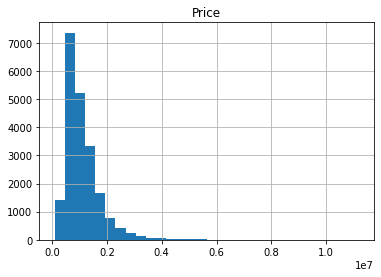

In [1997]:
data.hist(column='Price', bins=30)
data['Price'].quantile(0.9)

## Removing Outliers

<p>Here we are removing the entries for which the target variable is beyond |0.01| quantile</p>

In [1802]:
quantile_margin = 0.01
columns = ['Price']
for column in columns:
    if data[column].dtype == 'float64':
        upper = data[column].quantile(1 - quantile_margin)
        lower = data[column].quantile(0 + quantile_margin)
        data = data[(data[column].isnull()) | ((data[column] < upper) & (data[column] > lower))]

#### _________

## Correlation Matrix for Continious Features

<p>A correlation matrix will help us understand dependencies in the data</p>

<AxesSubplot:>

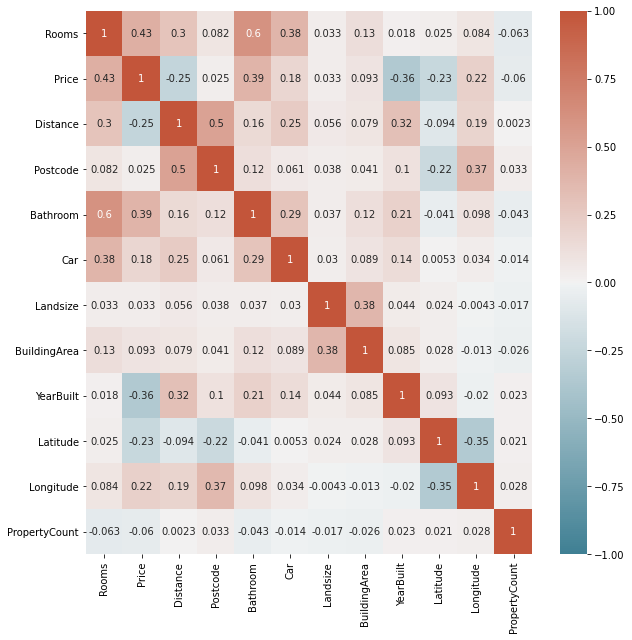

In [1803]:
corrmat = data.corr()
f, ax = plt.subplots(figsize=(10, 10))
sbrn.heatmap(corrmat, annot=True, cmap=sbrn.diverging_palette(220, 20, as_cmap=True), vmin=-1, vmax=1)

In [1804]:
## Postcode stands out in terms of both correlation and common sense
data = data.drop(columns=['Postcode'])

In [1805]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20375 entries, 1 to 34856
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         20375 non-null  object 
 1   Rooms          20375 non-null  float64
 2   Type           20375 non-null  object 
 3   Price          20375 non-null  float64
 4   Distance       20375 non-null  float64
 5   Bathroom       20375 non-null  float64
 6   Car            20001 non-null  float64
 7   Landsize       17598 non-null  float64
 8   BuildingArea   10427 non-null  float64
 9   YearBuilt      11814 non-null  float64
 10  CouncilArea    20375 non-null  object 
 11  Latitude       20353 non-null  float64
 12  Longitude      20353 non-null  float64
 13  RegionName     20375 non-null  object 
 14  PropertyCount  20375 non-null  float64
dtypes: float64(11), object(4)
memory usage: 2.5+ MB


#### _________

<p>There are not too many missing values for these categories. However, they are very important, so we do not fill them with mean/median, but rather delete the corresponding entries.</p>

In [1806]:
data = data[~data['Rooms'].isnull()]
data = data[~data['Bathroom'].isnull()]
data = data[~data['Latitude'].isnull()]
data = data[~data['Longitude'].isnull()]

In [1807]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20353 entries, 1 to 34856
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         20353 non-null  object 
 1   Rooms          20353 non-null  float64
 2   Type           20353 non-null  object 
 3   Price          20353 non-null  float64
 4   Distance       20353 non-null  float64
 5   Bathroom       20353 non-null  float64
 6   Car            19979 non-null  float64
 7   Landsize       17576 non-null  float64
 8   BuildingArea   10418 non-null  float64
 9   YearBuilt      11806 non-null  float64
 10  CouncilArea    20353 non-null  object 
 11  Latitude       20353 non-null  float64
 12  Longitude      20353 non-null  float64
 13  RegionName     20353 non-null  object 
 14  PropertyCount  20353 non-null  float64
dtypes: float64(11), object(4)
memory usage: 2.5+ MB


## Hot Encoding

<p>In this section we need to encode categorical features</p>

In [1808]:
def hot_encode(category, df):
    ohe = OneHotEncoder()
    print(np.unique(df[category].astype(str)))
    category_col = ohe.fit_transform(df[category].astype(str).values.reshape(-1, 1)).toarray()
    for i in range(len(category_col[0])):
        arr = []
        for x in category_col:
            arr.append(x[i])
        df[f'{category}{i}'] = arr

In [1809]:
def hot_encode_many(fields, df):
    for field in fields:
        print(field)
        hot_encode(field, df)

In [1810]:
## out of 'Suburb', 'RegionName', 'CouncilArea' we choose the latter as it has fewer missing values AND brings 
## better perfomance to our models based on the preliminarily runs 
hot_encodable_fields = ['Type', 'CouncilArea']
hot_encode_many(hot_encodable_fields, data)

Type
['h' 't' 'u']
CouncilArea
['Banyule City Council' 'Bayside City Council' 'Boroondara City Council'
 'Brimbank City Council' 'Cardinia Shire Council' 'Casey City Council'
 'Darebin City Council' 'Frankston City Council' 'Glen Eira City Council'
 'Greater Dandenong City Council' 'Hobsons Bay City Council'
 'Hume City Council' 'Kingston City Council' 'Knox City Council'
 'Macedon Ranges Shire Council' 'Manningham City Council'
 'Maribyrnong City Council' 'Maroondah City Council'
 'Melbourne City Council' 'Melton City Council' 'Mitchell Shire Council'
 'Monash City Council' 'Moonee Valley City Council'
 'Moorabool Shire Council' 'Moreland City Council'
 'Nillumbik Shire Council' 'Port Phillip City Council'
 'Stonnington City Council' 'Whitehorse City Council'
 'Whittlesea City Council' 'Wyndham City Council' 'Yarra City Council'
 'Yarra Ranges Shire Council']


In [1811]:
## drop the fields that we hot encoded, plus those that aren't rational to keep due to correlation 
## ('Suburn', 'RegionName') and too many missing values ('Suburb', 'RegionName', 'BuildingArea')
data = data.drop(columns=hot_encodable_fields+['Suburb', 'RegionName', 'BuildingArea'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20353 entries, 1 to 34856
Data columns (total 46 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rooms          20353 non-null  float64
 1   Price          20353 non-null  float64
 2   Distance       20353 non-null  float64
 3   Bathroom       20353 non-null  float64
 4   Car            19979 non-null  float64
 5   Landsize       17576 non-null  float64
 6   YearBuilt      11806 non-null  float64
 7   Latitude       20353 non-null  float64
 8   Longitude      20353 non-null  float64
 9   PropertyCount  20353 non-null  float64
 10  Type0          20353 non-null  float64
 11  Type1          20353 non-null  float64
 12  Type2          20353 non-null  float64
 13  CouncilArea0   20353 non-null  float64
 14  CouncilArea1   20353 non-null  float64
 15  CouncilArea2   20353 non-null  float64
 16  CouncilArea3   20353 non-null  float64
 17  CouncilArea4   20353 non-null  float64
 18  Counci

<AxesSubplot:title={'center':'A complete correlation matrix'}>

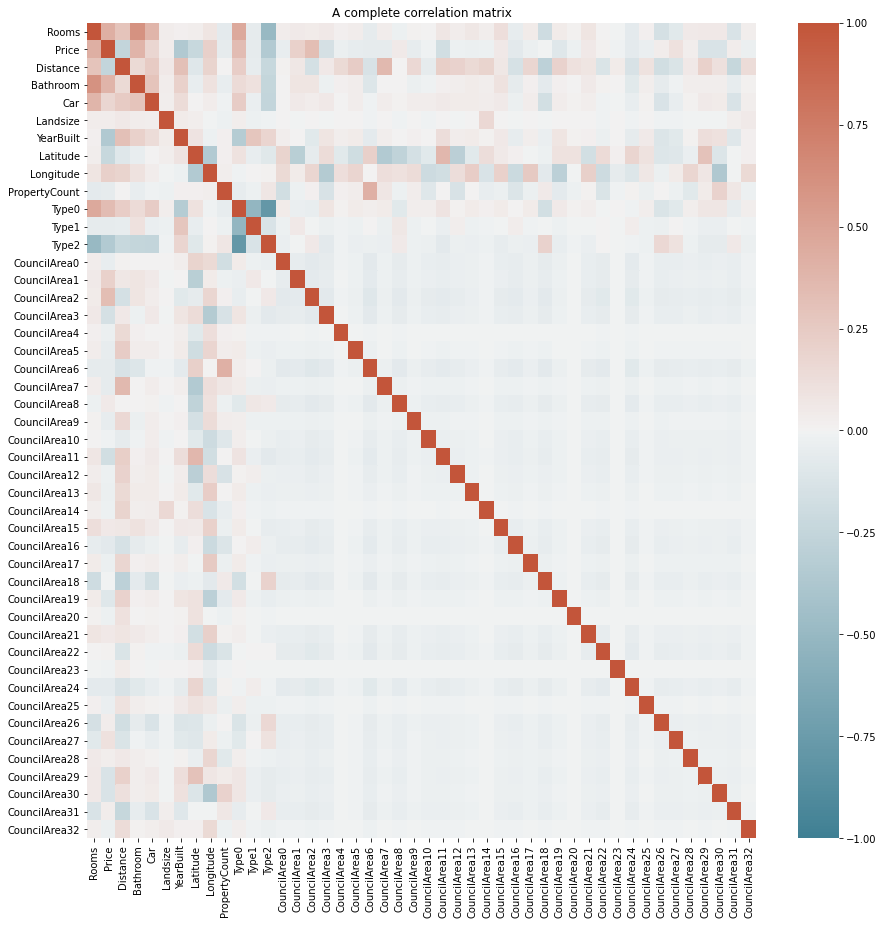

In [1812]:
corrmat = data.corr()
f, ax = plt.subplots(figsize=(15, 15))
ax.set_title("A complete correlation matrix")
sbrn.heatmap(corrmat, cmap=sbrn.diverging_palette(220, 20, as_cmap=True), vmin=-1, vmax=1)

#### _________

In [1813]:
## Landsize has a lot of 0 values, which is not actually true, we will deal with them further as missing values
data['Landsize'] = data['Landsize'].replace(['0', 0], np.nan)

## Removing Outliers: Part 2

<p>In this section we gain an understanding of how we will impute the missing values based on the distribution of a variable. At the same time, to understand the distribution, we need to remove some additional outliers</p>

In [1814]:
## get non-categorical column names

def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

def get_quantative(column_names):
    for x in column_names:
        if not hasNumbers(x) and x != "Price":
            yield x

In [1815]:
quantative_columns = list(get_quantative(data.columns))

In [1816]:
def normality_plot(df, columns):
    row = math.ceil(len(columns) / 2)
    col = 2
    f = plt.figure(figsize=(10,15))
    f.tight_layout()
    for idx, x in enumerate(columns):
        ax = f.add_subplot(row, col, idx+1)
        stats.probplot(df[x], dist="norm", plot=ax)
        ax.set_title(x, fontsize=12)
    plt.subplots_adjust(bottom=2, top=3, hspace=0.4, wspace=0.4)
    plt.show()

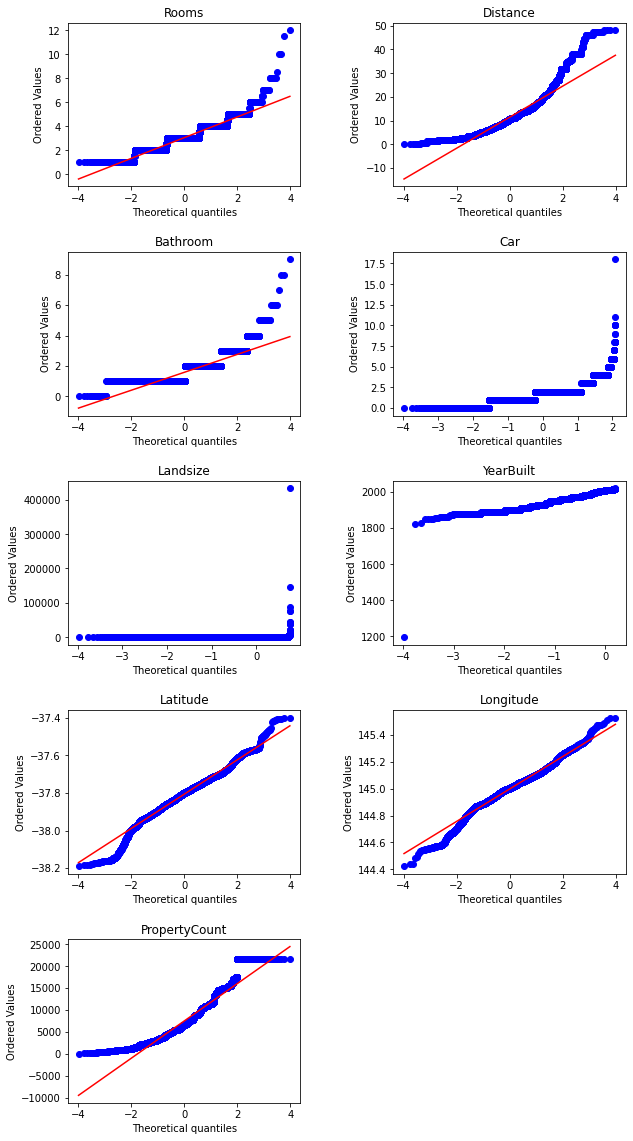

In [1817]:
normality_plot(data, quantative_columns)

In [1818]:
# remove some outliers which break the picture
data = data[(data['Car'].isnull()) | (data['Car'] < 12.5)]
data = data[(data['Bathroom'].isnull()) | (data['Bathroom'] < 8.5)]
data = data[(data['Landsize'].isnull()) | (data['Landsize'] < 8000)]
data = data[(data['YearBuilt'].isnull()) | (data['YearBuilt'] > 1300)]

In [1819]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20300 entries, 1 to 34856
Data columns (total 46 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rooms          20300 non-null  float64
 1   Price          20300 non-null  float64
 2   Distance       20300 non-null  float64
 3   Bathroom       20300 non-null  float64
 4   Car            19930 non-null  float64
 5   Landsize       15708 non-null  float64
 6   YearBuilt      11775 non-null  float64
 7   Latitude       20300 non-null  float64
 8   Longitude      20300 non-null  float64
 9   PropertyCount  20300 non-null  float64
 10  Type0          20300 non-null  float64
 11  Type1          20300 non-null  float64
 12  Type2          20300 non-null  float64
 13  CouncilArea0   20300 non-null  float64
 14  CouncilArea1   20300 non-null  float64
 15  CouncilArea2   20300 non-null  float64
 16  CouncilArea3   20300 non-null  float64
 17  CouncilArea4   20300 non-null  float64
 18  Counci

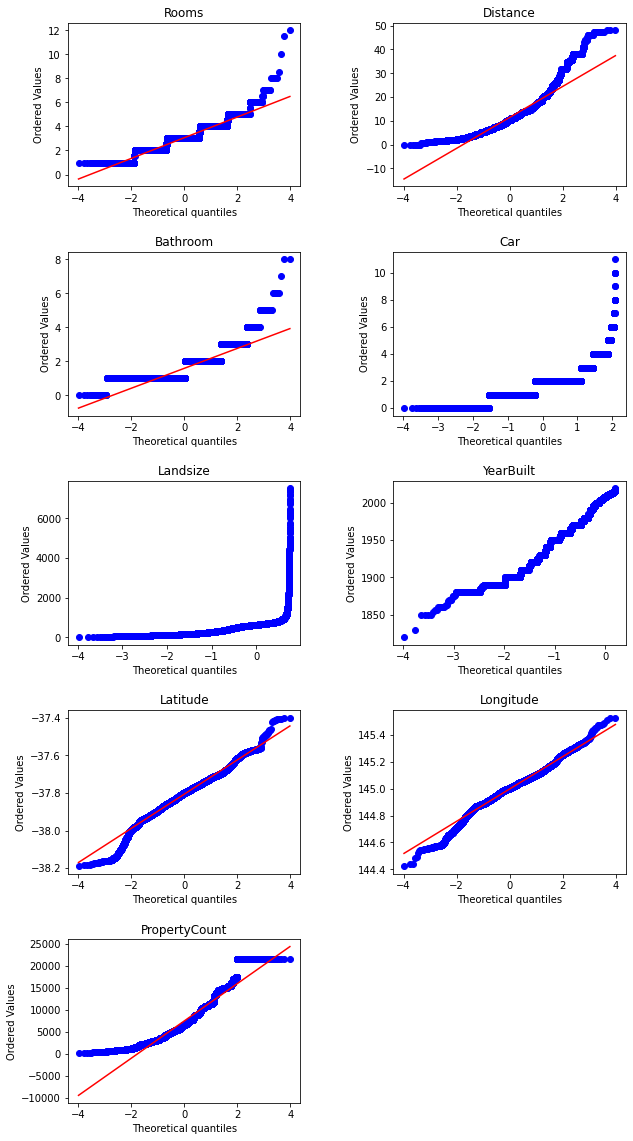

In [1820]:
normality_plot(data, quantative_columns)

In [1821]:
## based on the normality comparison, the columns, the null-values of which will be filled with median, will be those that
## significantly differ from a normal distribution
median_columns = ['Car', 'Bathroom', 'Landsize', 'Rooms']
mean_colums = list(set(quantative_columns) - set(median_columns))

#### _________

## Train-test splitting and Filling Null-Values for train and test data sets

In [1822]:
def fill_null_with_mean(df, columns, from_df):
    if from_df is not None:
        for name in columns:
            df[name].fillna(from_df[name].mean(), inplace=True)
    else:
        for name in columns:
            df[name].fillna(df[name].mean(), inplace=True)

In [1823]:
def fill_null_with_median(df, columns, from_df):
    if from_df is not None:
        for name in columns:
            df[name].fillna(from_df[name].median(), inplace=True)
    else:
        for name in columns:
            df[name].fillna(df[name].median(), inplace=True)

In [1824]:
Y = data['Price'] ## target variable
X = data.drop(columns=['Price']) ## everything except

In [1825]:
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), Y.to_numpy(), test_size=0.2, shuffle=False)

In [1826]:
X_train = pd.DataFrame(data=X_train, columns=X.columns)
X_test = pd.DataFrame(data=X_test, columns=X.columns)

In [1827]:
fill_null_with_mean(X_train, mean_colums, None)
fill_null_with_mean(X_test, mean_colums, X_train)

fill_null_with_median(X_train, median_columns, None)
fill_null_with_median(X_test, median_columns, X_train)

In [1828]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()
x = scaler_x.fit_transform(X_train)
y = scaler_y.fit_transform(y_train.reshape(len(y_train), 1))[:,0]

In [1829]:
## the test data need to be rescaled based on the training data
X_scaled_test = scaler_x.transform(X_test)
y_scaled_test = scaler_y.transform(y_test.reshape(len(y_test), 1))[:,0]

#### _________

In [1830]:
print(x.shape)
print(X_scaled_test.shape)
n = x.shape[1]

(16240, 45)
(4060, 45)


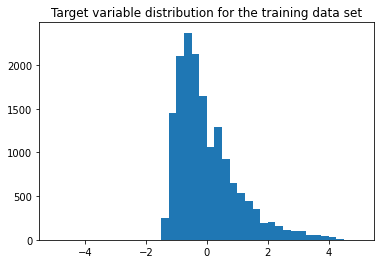

In [1831]:
fig, ax = plt.subplots()
ax.set_title("Target variable distribution for the training data set")
hist = ax.hist(y, bins=40, range=[-5, 5])

In [1893]:
## presenting comparison of real and predicted values
pd.set_option('display.float_format', lambda x: '%.2f' % x)

def sample_match(pred, real, open_pred, method_name):
    d = {f'prediction_{method_name}': [x[0] for x in pred] if open_pred else pred, 'real': real}
    return pd.DataFrame(data=d)

# ANN

In [1855]:
model = Sequential()
model.add(Dense(96, activation='relu', input_shape=(n,)))
model.add(Dense(96, activation='relu', kernel_regularizer='l2', kernel_initializer='he_uniform'))
model.add(Dense(48, kernel_regularizer='l2', kernel_initializer='he_uniform', activation='relu'))
model.add(Dense(48, kernel_regularizer='l2', kernel_initializer='he_uniform', activation='relu'))
model.add(Dense(16, kernel_regularizer='l2', kernel_initializer='he_uniform', activation='relu'))
model.add(Dense(8, kernel_regularizer='l2', kernel_initializer='he_uniform', activation='relu'))
model.add(Dense(1, activation='linear'))

In [1856]:
model.compile(optimizer=Adam(lr=0.001), 
              loss='mean_squared_error', metrics=['mse', 'mae'])

In [1857]:
# callbacks
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=0.00005)
early_stopping = EarlyStopping(monitor="val_loss", patience=7)
history = model.fit(x, y, epochs=150, batch_size=16, validation_split=0.1, 
                  callbacks=[reduce_lr, early_stopping], verbose=1)

Epoch 1/150
914/914 [==============================] - 2s 1ms/step - loss: 3.1271 - mse: 0.4541 - mae: 0.4589 - val_loss: 0.8962 - val_mse: 0.3450 - val_mae: 0.3618
Epoch 2/150
914/914 [==============================] - 1s 1ms/step - loss: 0.6608 - mse: 0.2604 - mae: 0.3518 - val_loss: 0.4404 - val_mse: 0.2691 - val_mae: 0.3354
Epoch 3/150
914/914 [==============================] - 1s 1ms/step - loss: 0.3909 - mse: 0.2441 - mae: 0.3399 - val_loss: 0.3544 - val_mse: 0.2568 - val_mae: 0.3316
Epoch 4/150
914/914 [==============================] - 1s 1ms/step - loss: 0.3154 - mse: 0.2251 - mae: 0.3287 - val_loss: 0.3013 - val_mse: 0.2268 - val_mae: 0.3213
Epoch 5/150
914/914 [==============================] - 1s 1ms/step - loss: 0.3004 - mse: 0.2298 - mae: 0.3314 - val_loss: 0.2903 - val_mse: 0.2281 - val_mae: 0.3315
Epoch 6/150
914/914 [==============================] - 1s 1ms/step - loss: 0.2759 - mse: 0.2148 - mae: 0.3210 - val_loss: 0.2838 - val_mse: 0.2274 - val_mae: 0.3285
Epoch 7/15

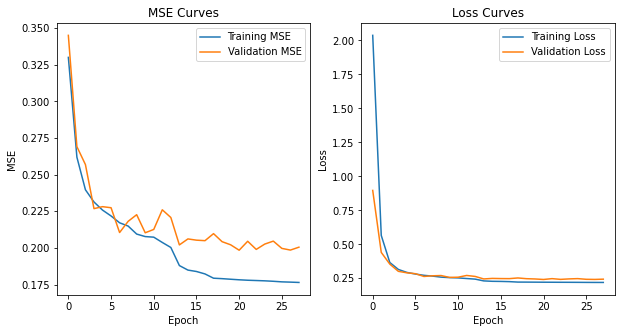

In [1858]:
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(['Training MSE',
           'Validation MSE'])
plt.title('MSE Curves')
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss',
           'Validation Loss'])
plt.title('Loss Curves')
plt.show()

In [2019]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_171 (Dense)            (None, 96)                4416      
_________________________________________________________________
dense_172 (Dense)            (None, 96)                9312      
_________________________________________________________________
dense_173 (Dense)            (None, 48)                4656      
_________________________________________________________________
dense_174 (Dense)            (None, 48)                2352      
_________________________________________________________________
dense_175 (Dense)            (None, 16)                784       
_________________________________________________________________
dense_176 (Dense)            (None, 8)                 136       
_________________________________________________________________
dense_177 (Dense)            (None, 1)               

In [1859]:
nn_results = model.predict(X_scaled_test)

In [1894]:
sample_match(nn_results[:25], y_scaled_test[:25], True, 'nn')

,prediction_nn,real
0,0.96,1.30
1,0.20,0.37
2,1.80,1.10
3,1.63,1.52
4,-0.94,-0.83
5,-1.15,-1.12
6,-1.14,-1.06
7,-1.13,-1.07
8,-0.04,-0.13
9,0.81,2.08


In [1895]:
num_samples = 15
nn_open = [x[0] for x in nn_results]
nn_inv = scaler_y.inverse_transform(nn_open[:num_samples])
real_inv = scaler_y.inverse_transform(y_scaled_test[:num_samples])
sample_nn = sample_match(nn_inv[:num_samples], real_inv[:num_samples], False, 'nn')
sample_nn

,prediction_nn,real
0,1590610.75,1777000.00
1,1169917.62,1260000.00
2,2054581.12,1665000.00
3,1960793.38,1900000.00
4,536961.69,600000.00
5,420371.91,440000.00
6,427743.66,470000.00
7,430012.59,468000.00
8,1033919.88,985000.00
9,1505111.00,2210000.00


In [1881]:
r2_score(nn_results, y_scaled_test)

0.7644017925761162

In [1882]:
mean_squared_error(nn_results, y_scaled_test)

0.1933677949033325

# SVM

<p>The grid search is commented out as it takes a long time to complete, its best parameters are presented below </p>

In [ ]:
# grid search
# param_grid = {'C': [0.1, 1, 10, 50], 'gamma': ['scale', 1, 0.1, 0.01, 0.001], 
#                   'kernel': ['rbf', 'poly']}
# grid = GridSearchCV(SVR(), param_grid, verbose=2, refit=True, n_jobs=-1)
# grid.fit(x, y)
# print(grid.best_params_)
# svm = SVR(kernel=grid.best_params_['kernel'], C=grid.best_params_['C'], gamma=grid.best_params_['gamma'])

In [1864]:
svm = SVR(kernel='rbf', C=10, gamma='scale')

In [1865]:
svm.fit(x, y)

SVR(C=10)

In [1866]:
svm_results = svm.predict(X_scaled_test)

In [1867]:
r2_score(svm_results, y_scaled_test)

0.7657549858465778

In [1868]:
mean_squared_error(svm_results, y_scaled_test)

0.17970865956370838

In [1896]:
svm_inv = scaler_y.inverse_transform(svm_results[:num_samples])
sample_svm = sample_match(svm_inv[:num_samples], real_inv[:num_samples], False, 'svm')
sample_svm

,prediction_svm,real
0,1460931.22,1777000.00
1,1133283.17,1260000.00
2,1928438.12,1665000.00
3,1754572.61,1900000.00
4,622412.07,600000.00
5,478416.67,440000.00
6,505065.52,470000.00
7,518705.78,468000.00
8,1012990.74,985000.00
9,1303595.59,2210000.00


## Random Forest

<p>The grid search is commented out as it takes a long time to complete, its best parameters are presented below</p>

In [2004]:
# Grid Search Initial Parameters

# param_grid = {
#     'bootstrap': [True, False],
#     'max_depth': [10, 50, 100, None],
#     'max_features': ['auto', 'sqrt'],
#     'min_samples_leaf': [1, 2, 4],
#     'min_samples_split': [2, 5, 10],
#     'n_estimators': [500, 1000, 1500]
# }

In [2005]:
# narrowed down to:

# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [None],
#     'max_features': ['auto'],
#     'min_samples_leaf': [2],
#     'min_samples_split': [2],
#     'n_estimators': [1500]
# }

# grid = GridSearchCV(RandomForestRegressor(), param_grid, verbose=2, refit=True, n_jobs=-1)
# grid.fit(x, y)

In [2006]:
# print(grid.best_params_)

In [1871]:
# rfr = RandomForestRegressor(bootstrap=grid.best_params_['bootstrap'], max_features=grid.best_params_['max_features'], min_samples_leaf=grid.best_params_['min_samples_leaf'], min_samples_split=grid.best_params_['min_samples_split'], n_estimators=grid.best_params_['n_estimators'])

In [2007]:
rfr = RandomForestRegressor(bootstrap=True, max_depth=None, max_features='auto', min_samples_leaf=2, 
                            min_samples_split=2, n_estimators=1500)

In [2008]:
rfr.fit(x, y)

RandomForestRegressor(min_samples_leaf=2, n_estimators=1500)

In [2009]:
rfr_results = rfr.predict(X_scaled_test)

In [2010]:
r2_score(rfr_results, y_scaled_test)

0.7894672638824037

In [2011]:
mean_squared_error(rfr_results, y_scaled_test)

0.16318483456240665

In [1897]:
rfr_inv = scaler_y.inverse_transform(rfr_results[:num_samples])
sample_rfr = sample_match(rfr_inv[:num_samples], real_inv[:num_samples], False, 'rfr')
sample_rfr

,prediction_rfr,real
0,1638480.95,1777000.00
1,945310.51,1260000.00
2,1631331.93,1665000.00
3,1794781.00,1900000.00
4,626826.95,600000.00
5,491281.58,440000.00
6,511289.86,470000.00
7,499174.00,468000.00
8,1003153.28,985000.00
9,1438590.44,2210000.00


In [1877]:
imp = rfr.feature_importances_

In [1878]:
## "importance" of the features
sorted(list(zip(X.columns, rfr.feature_importances_)), key=lambda x: x[1], reverse=True)

[('Latitude', 0.17534868990467617),
 ('Longitude', 0.16279898936429865),
 ('Type2', 0.13060194776179662),
 ('Rooms', 0.12433317930121533),
 ('CouncilArea2', 0.11676968986552573),
 ('Distance', 0.08582349945928826),
 ('Landsize', 0.0822370632854161),
 ('Bathroom', 0.028740825871328996),
 ('YearBuilt', 0.026250023379663995),
 ('PropertyCount', 0.015754529093647673),
 ('Car', 0.010588884379355703),
 ('Type0', 0.009850363509005606),
 ('CouncilArea27', 0.007633405575375484),
 ('CouncilArea1', 0.006771964561019424),
 ('Type1', 0.004650050407968264),
 ('CouncilArea22', 0.0025761588182864445),
 ('CouncilArea26', 0.0023253006383835034),
 ('CouncilArea0', 0.0013434545032745243),
 ('CouncilArea18', 0.000974708102909546),
 ('CouncilArea16', 0.0007460048391096816),
 ('CouncilArea8', 0.000726615806397269),
 ('CouncilArea10', 0.0005858102254508007),
 ('CouncilArea6', 0.0005143378962829054),
 ('CouncilArea31', 0.000380031704957205),
 ('CouncilArea24', 0.00032354923847085706),
 ('CouncilArea21', 0.0003

#### _________

## Comparison of real results

In [1951]:
results = pd.merge(sample_nn, sample_svm, on="real").merge(sample_rfr, on="real")
results = results[sorted(results.columns.values)]
results['idx'] = [x for x in range(1, num_samples+1)]
results

,prediction_nn,prediction_rfr,prediction_svm,real,idx
0,1590610.75,1638480.95,1460931.22,1777000.00,1
1,1169917.62,945310.51,1133283.17,1260000.00,2
2,2054581.12,1631331.93,1928438.12,1665000.00,3
3,1960793.38,1794781.00,1754572.61,1900000.00,4
4,536961.69,626826.95,622412.07,600000.00,5
5,420371.91,491281.58,478416.67,440000.00,6
6,427743.66,511289.86,505065.52,470000.00,7
7,430012.59,499174.00,518705.78,468000.00,8
8,1033919.88,1003153.28,1012990.74,985000.00,9
9,1505111.00,1438590.44,1303595.59,2210000.00,10


In [1952]:
def plot_comparison_results(res):
    plt.plot( 'idx', 'prediction_nn', data=res, marker='', markerfacecolor='blue', color='skyblue', linestyle='dashed', linewidth=2)
    plt.plot( 'idx', 'prediction_svm', data=res, marker='', color='magenta', linestyle='dashed', linewidth=2)
    plt.plot( 'idx', 'prediction_rfr', data=res, marker='', color='green', linewidth=2, linestyle='dashed')
    plt.plot( 'idx', 'real', data=res, marker='', color='red', linewidth=2)
    # show legend
    plt.legend()
    plt.figure(figsize=(12, 12))

    # show graph
    plt.show()

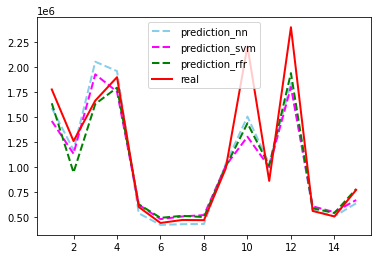

<Figure size 864x864 with 0 Axes>

In [1953]:
plot_comparison_results(results)

In [1954]:
results = results.sort_values(['real'], ascending=True)
results['idx'] = [x for x in range(1, num_samples+1)]

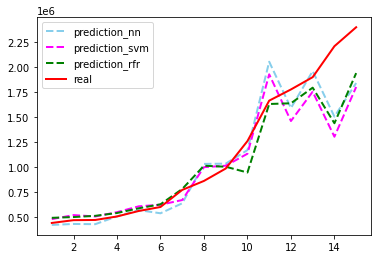

<Figure size 864x864 with 0 Axes>

In [1955]:
plot_comparison_results(results)